## 1 Housekeeping

### 1.1 Load libraries

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta

## 1.2 Load data

In [3]:
df = pd.read_csv("C:/Users/vandemey/OneDrive - TomTom/Documents/data_full.csv")

In [4]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,home_team_offense/away_team_goalkeeper,away_team_offense/home_team_goalkeeper,home_team_midfield/away_team_defense,away_team_midfield/home_team_defense,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,-37,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,6,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,59,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,21,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,-62,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 72 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   date                                    23921 non-null  object 
 1   home_team                               23921 non-null  object 
 2   away_team                               23921 non-null  object 
 3   home_team_continent                     23921 non-null  object 
 4   away_team_continent                     23921 non-null  object 
 5   home_team_fifa_rank                     23921 non-null  int64  
 6   away_team_fifa_rank                     23921 non-null  int64  
 7   fifa_rank_delta                         23921 non-null  int64  
 8   home_team_total_fifa_points             23921 non-null  int64  
 9   away_team_total_fifa_points             23921 non-null  int64  
 10  home_team_score                         23921 non-null  in

## 2 Feature engineering

### 2.1 Add EMA for Goals

In [172]:
df['home_team_score_total'] = df.apply(lambda row: row['home_team_score'] - row['away_team_score'], axis=1)
df['away_team_score_total'] = df.apply(lambda row: row['away_team_score'] - row['home_team_score'], axis=1)

In [216]:
# let's try a 5 day EMA
# https://sciencing.com/calculate-exponential-moving-averages-8221813.html

def calc_ema(number_of_days, current_rank, previous_ema):
    EMA = (current_rank - previous_ema)*(2/((number_of_days)+1)) + previous_ema
    return EMA

def get_x_day_EMA(country, number_of_days, column_home, column_away):
    df_temp_1 = df[df['home_team'] == country][['date','home_team',column_home]]
    df_temp_2 = df[df['away_team'] == country][['date','away_team',column_away]]

    df_temp_1 = df_temp_1.rename(columns={"home_team": "team", column_home: "rank"})
    df_temp_2 = df_temp_2.rename(columns={"away_team": "team", column_away: "rank"})
    #print(df_temp_1.head())
    #print(df_temp_2.head())

    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    result= result.sort_values(by=['date'])
    list_of_ranks = result['rank'].to_list()
    #print(list_of_ranks)

    first_five_tot = 0
    #print(number_of_days-1, len(list_of_ranks), (number_of_days-1)> len(list_of_ranks))
    if (number_of_days) < len(list_of_ranks):
        for x in range(0,number_of_days):
            #if country == 196:
                #print(first_five_tot,list_of_ranks[x])
            first_five_tot += list_of_ranks[x]
    else:
        for x in range(0,len(list_of_ranks)):
            first_five_tot += list_of_ranks[x]

    first_five_avg = first_five_tot/number_of_days
    #print(first_five_avg)

    EMA_list = []
    if (number_of_days) < len(list_of_ranks):
        for x in range(0,number_of_days):
            EMA_list.append(first_five_avg)
    else:
        for x in range(0,len(list_of_ranks)):
            EMA_list.append(first_five_avg)

    for x in range(number_of_days,len(list_of_ranks)):
        EMA_list.append(calc_ema(number_of_days,list_of_ranks[x],EMA_list[x-1]))
    #print(EMA_list)
    return EMA_list

In [217]:
countries_EMA_5_scores = {}

for x in df['home_team'].unique():
    countries_EMA_5_scores[x] = get_x_day_EMA(x, 5, 'home_team_score_total', 'away_team_score_total')

countries_EMA_10_scores = {}

for x in df['home_team'].unique():
    countries_EMA_10_scores[x] = get_x_day_EMA(x, 10, 'home_team_score_total', 'away_team_score_total')

countries_EMA_15_scores = {}

for x in df['home_team'].unique():
    countries_EMA_15_scores[x] = get_x_day_EMA(x, 15, 'home_team_score_total', 'away_team_score_total')

countries_EMA_20_scores = {}

for x in df['home_team'].unique():
    countries_EMA_20_scores[x] = get_x_day_EMA(x, 20, 'home_team_score_total', 'away_team_score_total')


In [218]:
countries_EMA_25_scores = {}

for x in df['home_team'].unique():
    countries_EMA_25_scores[x] = get_x_day_EMA(x, 25, 'home_team_score_total', 'away_team_score_total')

countries_EMA_30_scores = {}

for x in df['home_team'].unique():
    countries_EMA_30_scores[x] = get_x_day_EMA(x, 30, 'home_team_score_total', 'away_team_score_total')

countries_EMA_35_scores = {}

for x in df['home_team'].unique():
    countries_EMA_35_scores[x] = get_x_day_EMA(x, 35, 'home_team_score_total', 'away_team_score_total')

countries_EMA_40_scores = {}

for x in df['home_team'].unique():
    countries_EMA_40_scores[x] = get_x_day_EMA(x, 40, 'home_team_score_total', 'away_team_score_total')


In [219]:
def apply_EMA_home(row, dict):
    country = row.home_team
    this_date = row.date
    df_temp_1 = df[df['home_team'] == country][['date']]
    df_temp_2 = df[df['away_team'] == country][['date']]

    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    result = result.sort_values(by=['date'])

    dates = result['date'].to_list()

    index_date = dates.index(this_date)
    return dict[country][index_date]

def apply_EMA_away(row, dict):
    country = row.away_team
    this_date = row.date
    df_temp_1 = df[df['home_team'] == country][['date']]
    df_temp_2 = df[df['away_team'] == country][['date']]

    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    result = result.sort_values(by=['date'])

    dates = result['date'].to_list()

    index_date = dates.index(this_date)
    return dict[country][index_date]

In [266]:
def apply_EMA_home_time_series(row, dict):
    '''Exactly the same as the apply_EMA_home but this time we ascribe the result of this EMA result for this match to the first upcoming match'''
    country = row.home_team
    this_date = row.date
    df_temp_1 = df[df['home_team'] == country][['date']]
    df_temp_2 = df[df['away_team'] == country][['date']]

    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    result = result.sort_values(by=['date'])

    dates = result['date'].to_list()

    index_date = dates.index(this_date)
    if index_date == 0:
        return dict[country][index_date]
    else:
        return dict[country][index_date-1]

def apply_EMA_away_time_series(row, dict):
    '''Exactly the same as the apply_EMA_away but this time we ascribe the result of this EMA result for this match to the first upcoming match'''
    country = row.away_team
    this_date = row.date
    df_temp_1 = df[df['home_team'] == country][['date']]
    df_temp_2 = df[df['away_team'] == country][['date']]

    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    result = result.sort_values(by=['date'])

    dates = result['date'].to_list()

    index_date = dates.index(this_date)
    if index_date == 0:
        return dict[country][index_date]
    else:
        return dict[country][index_date-1]

In [220]:
df['EMA_5_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_5_scores), axis=1)
df['EMA_10_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_10_scores), axis=1)
df['EMA_15_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_15_scores), axis=1)
df['EMA_20_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_20_scores), axis=1)

In [221]:
df['EMA_25_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_25_scores), axis=1)
df['EMA_30_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_30_scores), axis=1)
df['EMA_35_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_35_scores), axis=1)
df['EMA_40_home_scores'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_40_scores), axis=1)

In [222]:
df['EMA_5_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_5_scores), axis=1)
df['EMA_10_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_10_scores), axis=1)
df['EMA_15_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_15_scores), axis=1)
df['EMA_20_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_20_scores), axis=1)

In [223]:
df['EMA_25_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_25_scores), axis=1)
df['EMA_30_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_30_scores), axis=1)
df['EMA_35_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_35_scores), axis=1)
df['EMA_40_away_scores'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_40_scores), axis=1)

In [267]:
df['EMA_5_home_scores_TS'] = df.apply(lambda row: apply_EMA_home_time_series(row, countries_EMA_5_scores), axis=1)
df['EMA_5_away_scores_TS'] = df.apply(lambda row: apply_EMA_away_time_series(row, countries_EMA_5_scores), axis=1)

In [270]:
df['EMA_20_home_scores_TS'] = df.apply(lambda row: apply_EMA_home_time_series(row, countries_EMA_20_scores), axis=1)
df['EMA_20_away_scores_TS'] = df.apply(lambda row: apply_EMA_away_time_series(row, countries_EMA_20_scores), axis=1)

In [277]:
df['EMA_40_home_scores_TS'] = df.apply(lambda row: apply_EMA_home_time_series(row, countries_EMA_40_scores), axis=1)
df['EMA_40_away_scores_TS'] = df.apply(lambda row: apply_EMA_away_time_series(row, countries_EMA_40_scores), axis=1)

In [265]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,EMA_35_home_results,EMA_40_home_results,EMA_5_away_results,EMA_10_away_results,EMA_15_away_results,EMA_20_away_results,EMA_25_away_results,EMA_30_away_results,EMA_35_away_results,EMA_40_away_results
0,1993-08-08,24,202,5,5,59,22,-37,0,0,...,0.514286,0.550,1.0,0.5,0.533333,0.50,0.44,0.500000,0.514286,0.550
1,1993-08-08,27,124,5,3,8,14,6,0,0,...,0.857143,0.875,0.6,0.8,0.800000,0.80,0.80,0.833333,0.857143,0.875
2,1993-08-08,59,205,5,5,35,94,59,0,0,...,0.685714,0.700,0.6,0.6,0.600000,0.65,0.68,0.733333,0.685714,0.700
3,1993-08-08,82,166,0,0,65,86,21,0,0,...,0.657143,0.700,0.8,0.6,0.600000,0.65,0.68,0.633333,0.657143,0.700
4,1993-08-08,148,8,5,5,67,5,-62,0,0,...,0.542857,0.550,-0.2,0.4,0.466667,0.50,0.52,0.600000,0.542857,0.550


### 2.2 Add EMA for fifa ranking

In [224]:
countries_EMA_5 = {}

for x in df['home_team'].unique():
    countries_EMA_5[x] = get_x_day_EMA(x, 5, 'home_team_fifa_rank', 'away_team_fifa_rank')

countries_EMA_10 = {}

for x in df['home_team'].unique():
    countries_EMA_10[x] = get_x_day_EMA(x, 10, 'home_team_fifa_rank', 'away_team_fifa_rank')

countries_EMA_15 = {}

for x in df['home_team'].unique():
    countries_EMA_15[x] = get_x_day_EMA(x, 15, 'home_team_fifa_rank', 'away_team_fifa_rank')

countries_EMA_20 = {}

for x in df['home_team'].unique():
    countries_EMA_20[x] = get_x_day_EMA(x, 20, 'home_team_fifa_rank', 'away_team_fifa_rank')


In [225]:
countries_EMA_25 = {}

for x in df['home_team'].unique():
    countries_EMA_25[x] = get_x_day_EMA(x, 25, 'home_team_fifa_rank', 'away_team_fifa_rank')

countries_EMA_30 = {}

for x in df['home_team'].unique():
    countries_EMA_30[x] = get_x_day_EMA(x, 30, 'home_team_fifa_rank', 'away_team_fifa_rank')

countries_EMA_35 = {}

for x in df['home_team'].unique():
    countries_EMA_35[x] = get_x_day_EMA(x, 35, 'home_team_fifa_rank', 'away_team_fifa_rank')

countries_EMA_40 = {}

for x in df['home_team'].unique():
    countries_EMA_40[x] = get_x_day_EMA(x, 40, 'home_team_fifa_rank', 'away_team_fifa_rank')

In [226]:
df['EMA_5_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_5), axis=1)
df['EMA_10_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_10), axis=1)
df['EMA_15_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_15), axis=1)
df['EMA_20_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_20), axis=1)

In [227]:
df['EMA_25_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_25), axis=1)
df['EMA_30_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_30), axis=1)
df['EMA_35_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_35), axis=1)
df['EMA_40_home'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_40), axis=1)

In [228]:
df['EMA_5_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_5), axis=1)
df['EMA_10_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_10), axis=1)
df['EMA_15_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_15), axis=1)
df['EMA_20_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_20), axis=1)

In [229]:
df['EMA_25_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_25), axis=1)
df['EMA_30_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_30), axis=1)
df['EMA_35_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_35), axis=1)
df['EMA_40_away'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_40), axis=1)

In [230]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,EMA_35_home_scores,EMA_40_home_scores,EMA_5_away_scores,EMA_10_away_scores,EMA_15_away_scores,EMA_20_away_scores,EMA_25_away_scores,EMA_30_away_scores,EMA_35_away_scores,EMA_40_away_scores
0,1993-08-08,24,202,5,5,59,22,-37,0,0,...,-0.028571,-0.150,0.8,-0.3,0.266667,0.45,0.36,0.133333,0.085714,0.025
1,1993-08-08,27,124,5,3,8,14,6,0,0,...,1.800000,1.875,1.0,0.8,0.066667,0.20,0.44,0.200000,0.257143,0.350
2,1993-08-08,59,205,5,5,35,94,59,0,0,...,0.342857,0.275,-3.8,-2.7,-2.333333,-2.30,-2.00,-1.966667,-2.000000,-1.925
3,1993-08-08,82,166,0,0,65,86,21,0,0,...,0.314286,0.275,-1.2,-0.8,-0.600000,-0.10,0.12,-0.233333,-0.285714,-0.325
4,1993-08-08,148,8,5,5,67,5,-62,0,0,...,0.285714,0.225,-0.6,-0.1,0.333333,0.50,0.48,0.566667,0.600000,0.600


### 2.3 Add EMA for total "scores" of offense/defense/midfield/goalkeeper

In [241]:
df['total_players_score_home'] = df.apply(lambda row: row.home_team_goalkeeper_score + row.home_team_defense_score + row.home_team_midfield_score + row.home_team_offense_score, axis=1)

In [242]:
df['total_players_score_away'] = df.apply(lambda row: row.away_team_goalkeeper_score + row.away_team_defense_score + row.away_team_midfield_score + row.away_team_offense_score, axis=1)

In [245]:
countries_EMA_5_tps = {}

for x in df['home_team'].unique():
    countries_EMA_5_tps[x] = get_x_day_EMA(x, 5, 'total_players_score_home', 'total_players_score_away')

countries_EMA_10_tps = {}

for x in df['home_team'].unique():
    countries_EMA_10_tps[x] = get_x_day_EMA(x, 10, 'total_players_score_home', 'total_players_score_away')

countries_EMA_15_tps = {}

for x in df['home_team'].unique():
    countries_EMA_15_tps[x] = get_x_day_EMA(x, 15, 'total_players_score_home', 'total_players_score_away')

countries_EMA_20_tps = {}

for x in df['home_team'].unique():
    countries_EMA_20_tps[x] = get_x_day_EMA(x, 20, 'total_players_score_home', 'total_players_score_away')


In [248]:
countries_EMA_25_tps = {}

for x in df['home_team'].unique():
    countries_EMA_25_tps[x] = get_x_day_EMA(x, 25, 'total_players_score_home', 'total_players_score_away')

countries_EMA_30_tps = {}

for x in df['home_team'].unique():
    countries_EMA_30_tps[x] = get_x_day_EMA(x, 30, 'total_players_score_home', 'total_players_score_away')

countries_EMA_35_tps = {}

for x in df['home_team'].unique():
    countries_EMA_35_tps[x] = get_x_day_EMA(x, 35, 'total_players_score_home', 'total_players_score_away')

countries_EMA_40_tps = {}

for x in df['home_team'].unique():
    countries_EMA_40_tps[x] = get_x_day_EMA(x, 40, 'total_players_score_home', 'total_players_score_away')

In [246]:
df['EMA_5_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_5_tps), axis=1)
df['EMA_10_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_10_tps), axis=1)
df['EMA_15_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_15_tps), axis=1)
df['EMA_20_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_20_tps), axis=1)

In [249]:
df['EMA_25_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_25_tps), axis=1)
df['EMA_30_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_30_tps), axis=1)
df['EMA_35_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_35_tps), axis=1)
df['EMA_40_home_tps'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_40_tps), axis=1)

In [247]:
df['EMA_5_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_5_tps), axis=1)
df['EMA_10_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_10_tps), axis=1)
df['EMA_15_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_15_tps), axis=1)
df['EMA_20_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_20_tps), axis=1)

In [250]:
df['EMA_25_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_25_tps), axis=1)
df['EMA_30_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_30_tps), axis=1)
df['EMA_35_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_35_tps), axis=1)
df['EMA_40_away_tps'] = df.apply(lambda row: apply_EMA_away(row, countries_EMA_40_tps), axis=1)

### 2.4 Add EMA for results

In [254]:
df['away_team_result'] = df.apply(lambda row: 1 if row.home_team_result == -1 else
                                  0 if row.home_team_result == 0 else 1, axis=1)

In [255]:
countries_EMA_5_results = {}

for x in df['home_team'].unique():
    countries_EMA_5_results[x] = get_x_day_EMA(x, 5, 'home_team_result', 'away_team_result')

countries_EMA_10_results = {}

for x in df['home_team'].unique():
    countries_EMA_10_results[x] = get_x_day_EMA(x, 10, 'home_team_result', 'away_team_result')

countries_EMA_15_results = {}

for x in df['home_team'].unique():
    countries_EMA_15_results[x] = get_x_day_EMA(x, 15, 'home_team_result', 'away_team_result')

countries_EMA_20_results = {}

for x in df['home_team'].unique():
    countries_EMA_20_results[x] = get_x_day_EMA(x, 20, 'home_team_result', 'away_team_result')


In [257]:
countries_EMA_25_results = {}

for x in df['home_team'].unique():
    countries_EMA_25_results[x] = get_x_day_EMA(x, 25, 'home_team_result', 'away_team_result')

countries_EMA_30_results = {}

for x in df['home_team'].unique():
    countries_EMA_30_results[x] = get_x_day_EMA(x, 30, 'home_team_result', 'away_team_result')

countries_EMA_35_results = {}

for x in df['home_team'].unique():
    countries_EMA_35_results[x] = get_x_day_EMA(x, 35, 'home_team_result', 'away_team_result')

countries_EMA_40_results = {}

for x in df['home_team'].unique():
    countries_EMA_40_results[x] = get_x_day_EMA(x, 40, 'home_team_result', 'away_team_result')


In [256]:
df['EMA_5_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_5_results), axis=1)
df['EMA_10_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_10_results), axis=1)
df['EMA_15_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_15_results), axis=1)
df['EMA_20_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_20_results), axis=1)

In [258]:
df['EMA_25_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_25_results), axis=1)
df['EMA_30_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_30_results), axis=1)
df['EMA_35_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_35_results), axis=1)
df['EMA_40_home_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_40_results), axis=1)

In [259]:
df['EMA_5_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_5_results), axis=1)
df['EMA_10_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_10_results), axis=1)
df['EMA_15_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_15_results), axis=1)
df['EMA_20_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_20_results), axis=1)

In [260]:
df['EMA_25_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_25_results), axis=1)
df['EMA_30_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_30_results), axis=1)
df['EMA_35_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_35_results), axis=1)
df['EMA_40_away_results'] = df.apply(lambda row: apply_EMA_home(row, countries_EMA_40_results), axis=1)

In [288]:
df['EMA_5_home_results_TS'] = df.apply(lambda row: apply_EMA_home_time_series(row, countries_EMA_5_results), axis=1)
df['EMA_5_away_results_TS'] = df.apply(lambda row: apply_EMA_away_time_series(row, countries_EMA_5_results), axis=1)

df['EMA_20_home_results_TS'] = df.apply(lambda row: apply_EMA_home_time_series(row, countries_EMA_20_results), axis=1)
df['EMA_20_away_results_TS'] = df.apply(lambda row: apply_EMA_away_time_series(row, countries_EMA_20_results), axis=1)

df['EMA_40_home_results_TS'] = df.apply(lambda row: apply_EMA_home_time_series(row, countries_EMA_40_results), axis=1)
df['EMA_40_away_results_TS'] = df.apply(lambda row: apply_EMA_away_time_series(row, countries_EMA_40_results), axis=1)

### 2.5 Number of days since previous game

In [349]:
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')

In [354]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,EMA_40_away_scores_TS,EMA_5_home_results_TS,EMA_20_home_results_TS,EMA_40_home_results_TS,EMA_5_away_results_TS,EMA_20_away_results_TS,EMA_40_away_results_TS,days_since_previous_match,days_since_previous_match_home,days_since_previous_match_away
0,1993-08-08,24,202,5,5,59,22,-37,0,0,...,0.025,1.0,0.50,0.550,0.8,0.70,0.725,NaT,NaT,NaT
1,1993-08-08,27,124,5,3,8,14,6,0,0,...,0.350,0.6,0.80,0.875,0.4,0.25,0.400,NaT,NaT,NaT
2,1993-08-08,59,205,5,5,35,94,59,0,0,...,-1.925,0.6,0.65,0.700,1.0,0.40,0.425,NaT,NaT,NaT
3,1993-08-08,82,166,0,0,65,86,21,0,0,...,-0.325,0.8,0.65,0.700,0.2,0.70,0.650,NaT,NaT,NaT
4,1993-08-08,148,8,5,5,67,5,-62,0,0,...,0.600,-0.2,0.50,0.550,0.4,0.60,0.575,NaT,NaT,NaT


In [365]:
def get_days_since_last_match(row, team):
    current_date = row.date
    df_temp = df[df['date'] < current_date]
    df_temp_1 = df_temp[df_temp['home_team'] == team][['date']]
    df_temp_2 = df_temp[df_temp['away_team'] == team][['date']]
    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    result= result.sort_values(by=['date'])

    date_list = result['date'].to_list()

    if len(date_list) > 0:
        previous_match_date = date_list[-1]
        delta = current_date - previous_match_date
        return delta
    else:
        return(np.nan)

In [366]:
df['days_since_previous_match_home'] = df.apply(lambda row: get_days_since_last_match(row, row.home_team), axis=1)
df['days_since_previous_match_away'] = df.apply(lambda row: get_days_since_last_match(row, row.away_team), axis=1)

In [368]:
df[(df['home_team'] == 67) | (df['away_team'] == 67)][['date','days_since_previous_match_home','days_since_previous_match_away','home_team','away_team']]

,date,days_since_previous_match_home,days_since_previous_match_away,home_team,away_team
478,1994-09-04,NaT,331 days,67,2
555,1994-10-15,42 days,41 days,199,67
580,1994-11-11,28 days,27 days,60,67
676,1995-01-08,58 days,31 days,67,187
692,1995-01-22,14 days,71 days,67,179
...,...,...,...,...,...
23525,2022-03-25,60 days,67 days,44,67
23646,2022-05-28,64 days,62 days,67,109
23650,2022-05-30,2 days,2 days,67,109
23724,2022-06-05,131 days,6 days,117,67


### 2.6 Number of games in the last 100 days

In [388]:
def get_no_games_past_100_days(row, team):
    current_date = row.date
    days_ago_100 = str(current_date-timedelta(days=101))
    print(type(days_ago_100), days_ago_100)
    days_ago_100 = days_ago_100.strptime('%Y-%m-%d')
    df_temp = df[(df['date'] > days_ago_100) & (df['date'] < current_date)]
    df_temp_1 = df_temp[df_temp['home_team'] == team][['date']]
    df_temp_2 = df_temp[df_temp['away_team'] == team][['date']]
    frames = [df_temp_1, df_temp_2]
    result = pd.concat(frames)
    date_list = result['date'].to_list()
    if team == 67:
        print("Ago: ", days_ago_100, "Current: ", current_date, result.head())
    return(len(date_list))

In [389]:
df['no_games_past_100_days_home'] = df.apply(lambda row: get_no_games_past_100_days(row, row.home_team), axis=1)
df['no_games_past_100_days_away'] = df.apply(lambda row: get_no_games_past_100_days(row, row.away_team), axis=1)

<class 'str'> 1993-04-29 00:00:00


AttributeError: 'str' object has no attribute 'strptime'

In [381]:
df[(df['home_team'] == 67) | (df['away_team'] == 67)][['date','no_games_past_100_days_home','no_games_past_100_days_away','home_team','away_team']]

,date,no_games_past_100_days_home,no_games_past_100_days_away,home_team,away_team
478,1994-09-04,0,0,67,2
555,1994-10-15,1,1,199,67
580,1994-11-11,6,2,60,67
676,1995-01-08,2,4,67,187
692,1995-01-22,3,2,67,179
...,...,...,...,...,...
23525,2022-03-25,5,4,44,67
23646,2022-05-28,1,2,67,109
23650,2022-05-30,2,3,67,109
23724,2022-06-05,0,3,117,67


### 2.7 Continent Temperature or Country Temperature on given date

### 2.8 Min- Max- temperatures (on avg) for home-team and away-team

## 3 Encoding Categorical columns

#### 3.1 Home- & Away-team

In [74]:
# converting type of columns to 'category'
df['home_team'] = df['home_team'].astype('category')
# create a dict with the values
c = df['home_team'].astype('category')
d = dict(enumerate(c.cat.categories))
# Assigning numerical values and storing in another column
df['home_team'] = df['home_team'].cat.codes
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,away_team_mean_offense_score,away_team_mean_midfield_score,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away
0,1993-08-08,24,Uruguay,South America,South America,59,22,-37,0,0,...,NaN,NaN,62.4,20.2,62.4,62.4,62.4,20.2,20.2,20.2
1,1993-08-08,27,Mexico,South America,North America,8,14,6,0,0,...,NaN,NaN,6.6,13.8,6.6,6.6,6.6,13.8,13.8,13.8
2,1993-08-08,59,Venezuela,South America,South America,35,94,59,0,0,...,NaN,NaN,37.2,86.8,37.2,37.2,37.2,86.8,86.8,86.8
3,1993-08-08,82,Sierra Leone,Africa,Africa,65,86,21,0,0,...,NaN,NaN,67.0,89.6,67.0,67.0,67.0,89.6,89.6,89.6
4,1993-08-08,148,Argentina,South America,South America,67,5,-62,0,0,...,NaN,NaN,63.6,4.8,63.6,63.6,63.6,4.8,4.8,4.8


In [80]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,away_team_mean_offense_score,away_team_mean_midfield_score,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away
0,1993-08-08,24,202,South America,South America,59,22,-37,0,0,...,NaN,NaN,62.4,20.2,62.4,62.4,62.4,20.2,20.2,20.2
1,1993-08-08,27,124,South America,North America,8,14,6,0,0,...,NaN,NaN,6.6,13.8,6.6,6.6,6.6,13.8,13.8,13.8
2,1993-08-08,59,205,South America,South America,35,94,59,0,0,...,NaN,NaN,37.2,86.8,37.2,37.2,37.2,86.8,86.8,86.8
3,1993-08-08,82,166,Africa,Africa,65,86,21,0,0,...,NaN,NaN,67.0,89.6,67.0,67.0,67.0,89.6,89.6,89.6
4,1993-08-08,148,8,South America,South America,67,5,-62,0,0,...,NaN,NaN,63.6,4.8,63.6,63.6,63.6,4.8,4.8,4.8


In [76]:
def iterate_dict(row):
    for key,value in d.items():
        if value == row.away_team:
            return key

In [78]:
df['away_team'] = df.apply(lambda row: iterate_dict(row), axis=1)

In [84]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,away_team_mean_offense_score,away_team_mean_midfield_score,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away
0,1993-08-08,24,202,South America,South America,59,22,-37,0,0,...,NaN,NaN,62.4,20.2,62.4,62.4,62.4,20.2,20.2,20.2
1,1993-08-08,27,124,South America,North America,8,14,6,0,0,...,NaN,NaN,6.6,13.8,6.6,6.6,6.6,13.8,13.8,13.8
2,1993-08-08,59,205,South America,South America,35,94,59,0,0,...,NaN,NaN,37.2,86.8,37.2,37.2,37.2,86.8,86.8,86.8
3,1993-08-08,82,166,Africa,Africa,65,86,21,0,0,...,NaN,NaN,67.0,89.6,67.0,67.0,67.0,89.6,89.6,89.6
4,1993-08-08,148,8,South America,South America,67,5,-62,0,0,...,NaN,NaN,63.6,4.8,63.6,63.6,63.6,4.8,4.8,4.8


#### 3.2 Home- & Away- continent

In [85]:
# converting type of columns to 'category'
df['home_team_continent'] = df['home_team_continent'].astype('category')
# create a dict with the values
c = df['home_team_continent'].astype('category')
d = dict(enumerate(c.cat.categories))
# Assigning numerical values and storing in another column
df['home_team_continent'] = df['home_team_continent'].cat.codes
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,away_team_mean_offense_score,away_team_mean_midfield_score,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away
0,1993-08-08,24,202,5,South America,59,22,-37,0,0,...,NaN,NaN,62.4,20.2,62.4,62.4,62.4,20.2,20.2,20.2
1,1993-08-08,27,124,5,North America,8,14,6,0,0,...,NaN,NaN,6.6,13.8,6.6,6.6,6.6,13.8,13.8,13.8
2,1993-08-08,59,205,5,South America,35,94,59,0,0,...,NaN,NaN,37.2,86.8,37.2,37.2,37.2,86.8,86.8,86.8
3,1993-08-08,82,166,0,Africa,65,86,21,0,0,...,NaN,NaN,67.0,89.6,67.0,67.0,67.0,89.6,89.6,89.6
4,1993-08-08,148,8,5,South America,67,5,-62,0,0,...,NaN,NaN,63.6,4.8,63.6,63.6,63.6,4.8,4.8,4.8


In [91]:
def iterate_dict(row, column):
    for key,value in d.items():
        if value == column:
            return key

In [92]:
df['away_team_continent'] = df.apply(lambda row: iterate_dict(row, row.away_team_continent), axis=1)

In [93]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,away_team_mean_offense_score,away_team_mean_midfield_score,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away
0,1993-08-08,24,202,5,5,59,22,-37,0,0,...,NaN,NaN,62.4,20.2,62.4,62.4,62.4,20.2,20.2,20.2
1,1993-08-08,27,124,5,3,8,14,6,0,0,...,NaN,NaN,6.6,13.8,6.6,6.6,6.6,13.8,13.8,13.8
2,1993-08-08,59,205,5,5,35,94,59,0,0,...,NaN,NaN,37.2,86.8,37.2,37.2,37.2,86.8,86.8,86.8
3,1993-08-08,82,166,0,0,65,86,21,0,0,...,NaN,NaN,67.0,89.6,67.0,67.0,67.0,89.6,89.6,89.6
4,1993-08-08,148,8,5,5,67,5,-62,0,0,...,NaN,NaN,63.6,4.8,63.6,63.6,63.6,4.8,4.8,4.8


#### 3.3 Tournament

In [95]:
df['tournament'].unique()

array(['FIFA World Cup qualification', 'Friendly',
       'African Cup of Nations qualification', 'Amílcar Cabral Cup',
       'CFU Caribbean Cup qualification',
       'United Arab Emirates Friendship Tournament',
       'Malta International Tournament', 'Lunar New Year Cup',
       'African Cup of Nations', 'CFU Caribbean Cup',
       'UEFA Euro qualification', 'Kirin Cup', 'FIFA World Cup',
       'Oceania Nations Cup qualification', 'Baltic Cup', 'Gulf Cup',
       'Simba Tournament', 'CECAFA Cup', 'Confederations Cup',
       'Dynasty Cup', "King's Cup", 'Nehru Cup', 'SAFF Cup',
       'Copa Paz del Chaco', 'Korea Cup', 'USA Cup', 'Copa América',
       'Merdeka Tournament', 'South Pacific Games', 'UNCAF Cup',
       'Oceania Nations Cup', 'Windward Islands Tournament', 'Gold Cup',
       'AFC Asian Cup qualification', 'UEFA Euro', 'AFF Championship',
       'AFC Asian Cup', 'King Hassan II Tournament',
       'Cyprus International Tournament', 'Dunhill Cup',
       'COSAFA Cup qu

In [99]:
df['tournament_friendly'] = df.apply(lambda row: 1 if row.tournament == "Friendly" else 0, axis=1)

In [97]:
df['tournament_qualification'] = df.apply(lambda row: 1 if "qualification"  in row.tournament else 0, axis=1 )

#### 3.4 Neutral location

In [103]:
df['neutral_location'] = df.apply(lambda row: 1 if row.neutral_location == True else 0, axis=1)

#### 3.5 Shoot out

In [105]:
df['shoot_out'] = df.apply(lambda row: 1 if row.shoot_out == "Yes" else 0, axis=1)

#### 3.6 Result

In [107]:
df['home_team_result'] = df.apply(lambda row: 1 if row.home_team_result == "Win" else
                                  -1 if row.home_team_result == "Lose" else 0, axis=1)

In [108]:
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away,tournament_friendly,tournament_qualification
23911,2022-06-14,200,155,2,2,27,47,20,1535,1449,...,26.867044,47.464123,26.458017,26.095763,25.872950,47.463943,46.588163,45.458724,0,0
23912,2022-06-14,25,70,2,2,59,57,-2,1388,1406,...,58.909277,57.076098,58.349907,57.416651,56.238737,56.923080,56.734316,56.742103,0,0
23913,2022-06-14,156,127,2,2,48,70,22,1446,1342,...,47.345485,70.318147,45.933677,44.592540,43.345067,69.959476,68.965674,67.814027,0,0
23914,2022-06-14,114,68,2,2,94,124,30,1229,1137,...,93.927831,123.200932,94.143017,94.372889,94.614774,120.829712,118.668896,116.911174,0,0
23915,2022-06-14,194,113,2,2,43,138,95,1461,1092,...,42.203287,137.645879,40.680917,39.364273,38.392955,136.782103,135.926832,135.130312,0,0
23916,2022-06-14,125,4,2,2,180,153,-27,932,1040,...,180.145606,153.325081,179.918372,179.371221,178.695832,153.410669,152.687504,151.840056,0,0
23917,2022-06-14,112,107,2,2,192,135,-57,895,1105,...,191.626932,135.075439,190.511370,189.318816,188.231704,135.374107,135.655901,135.737548,0,0
23918,2022-06-14,40,76,5,0,28,60,32,1526,1387,...,27.077700,59.407994,25.663633,24.496175,23.477601,57.686287,56.331421,55.305930,0,0
23919,2022-06-14,97,193,1,0,23,35,12,1553,1499,...,23.304237,34.656726,24.091415,24.838236,25.669959,33.457528,32.414728,31.616774,0,0
23920,2022-06-14,102,60,1,0,29,32,3,1519,1500,...,29.397971,34.041650,30.687195,31.995496,33.254236,37.189497,39.274971,40.746828,1,0


## 4 Fill NA

In [109]:
df = df.fillna(-666)

In [111]:
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,fifa_rank_delta,home_team_total_fifa_points,away_team_total_fifa_points,...,EMA_5_home,EMA_5_away,EMA_10_home,EMA_15_home,EMA_20_home,EMA_10_away,EMA_15_away,EMA_20_away,tournament_friendly,tournament_qualification
23911,2022-06-14,200,155,2,2,27,47,20,1535,1449,...,26.867044,47.464123,26.458017,26.095763,25.872950,47.463943,46.588163,45.458724,0,0
23912,2022-06-14,25,70,2,2,59,57,-2,1388,1406,...,58.909277,57.076098,58.349907,57.416651,56.238737,56.923080,56.734316,56.742103,0,0
23913,2022-06-14,156,127,2,2,48,70,22,1446,1342,...,47.345485,70.318147,45.933677,44.592540,43.345067,69.959476,68.965674,67.814027,0,0
23914,2022-06-14,114,68,2,2,94,124,30,1229,1137,...,93.927831,123.200932,94.143017,94.372889,94.614774,120.829712,118.668896,116.911174,0,0
23915,2022-06-14,194,113,2,2,43,138,95,1461,1092,...,42.203287,137.645879,40.680917,39.364273,38.392955,136.782103,135.926832,135.130312,0,0
23916,2022-06-14,125,4,2,2,180,153,-27,932,1040,...,180.145606,153.325081,179.918372,179.371221,178.695832,153.410669,152.687504,151.840056,0,0
23917,2022-06-14,112,107,2,2,192,135,-57,895,1105,...,191.626932,135.075439,190.511370,189.318816,188.231704,135.374107,135.655901,135.737548,0,0
23918,2022-06-14,40,76,5,0,28,60,32,1526,1387,...,27.077700,59.407994,25.663633,24.496175,23.477601,57.686287,56.331421,55.305930,0,0
23919,2022-06-14,97,193,1,0,23,35,12,1553,1499,...,23.304237,34.656726,24.091415,24.838236,25.669959,33.457528,32.414728,31.616774,0,0
23920,2022-06-14,102,60,1,0,29,32,3,1519,1500,...,29.397971,34.041650,30.687195,31.995496,33.254236,37.189497,39.274971,40.746828,1,0


## 5 Correlation Check

### 5.1 Fifa Rank

In [231]:
dependent = ['home_team_result']

In [273]:
cols = ['home_team_fifa_rank','away_team_fifa_rank','EMA_5_home','EMA_10_home','EMA_15_home', 'EMA_20_home','EMA_5_away','EMA_10_away','EMA_15_away','EMA_20_away','EMA_25_home','EMA_30_home','EMA_35_home', 'EMA_40_home','EMA_25_away','EMA_30_away','EMA_35_away','EMA_40_away']

- Pearson's correlation coefficient to calculate the correlations of the continuous variables
- Spearman's rank correlation coefficient for discrete and ordinal variables

uncorrelated = a correlation smaller than 0.1
very weak correlation = a correlation between 0.1 and 0.33
weak correlation = a correlation between 0.33 and 0.66
strong correlation = a correlation above 0.66

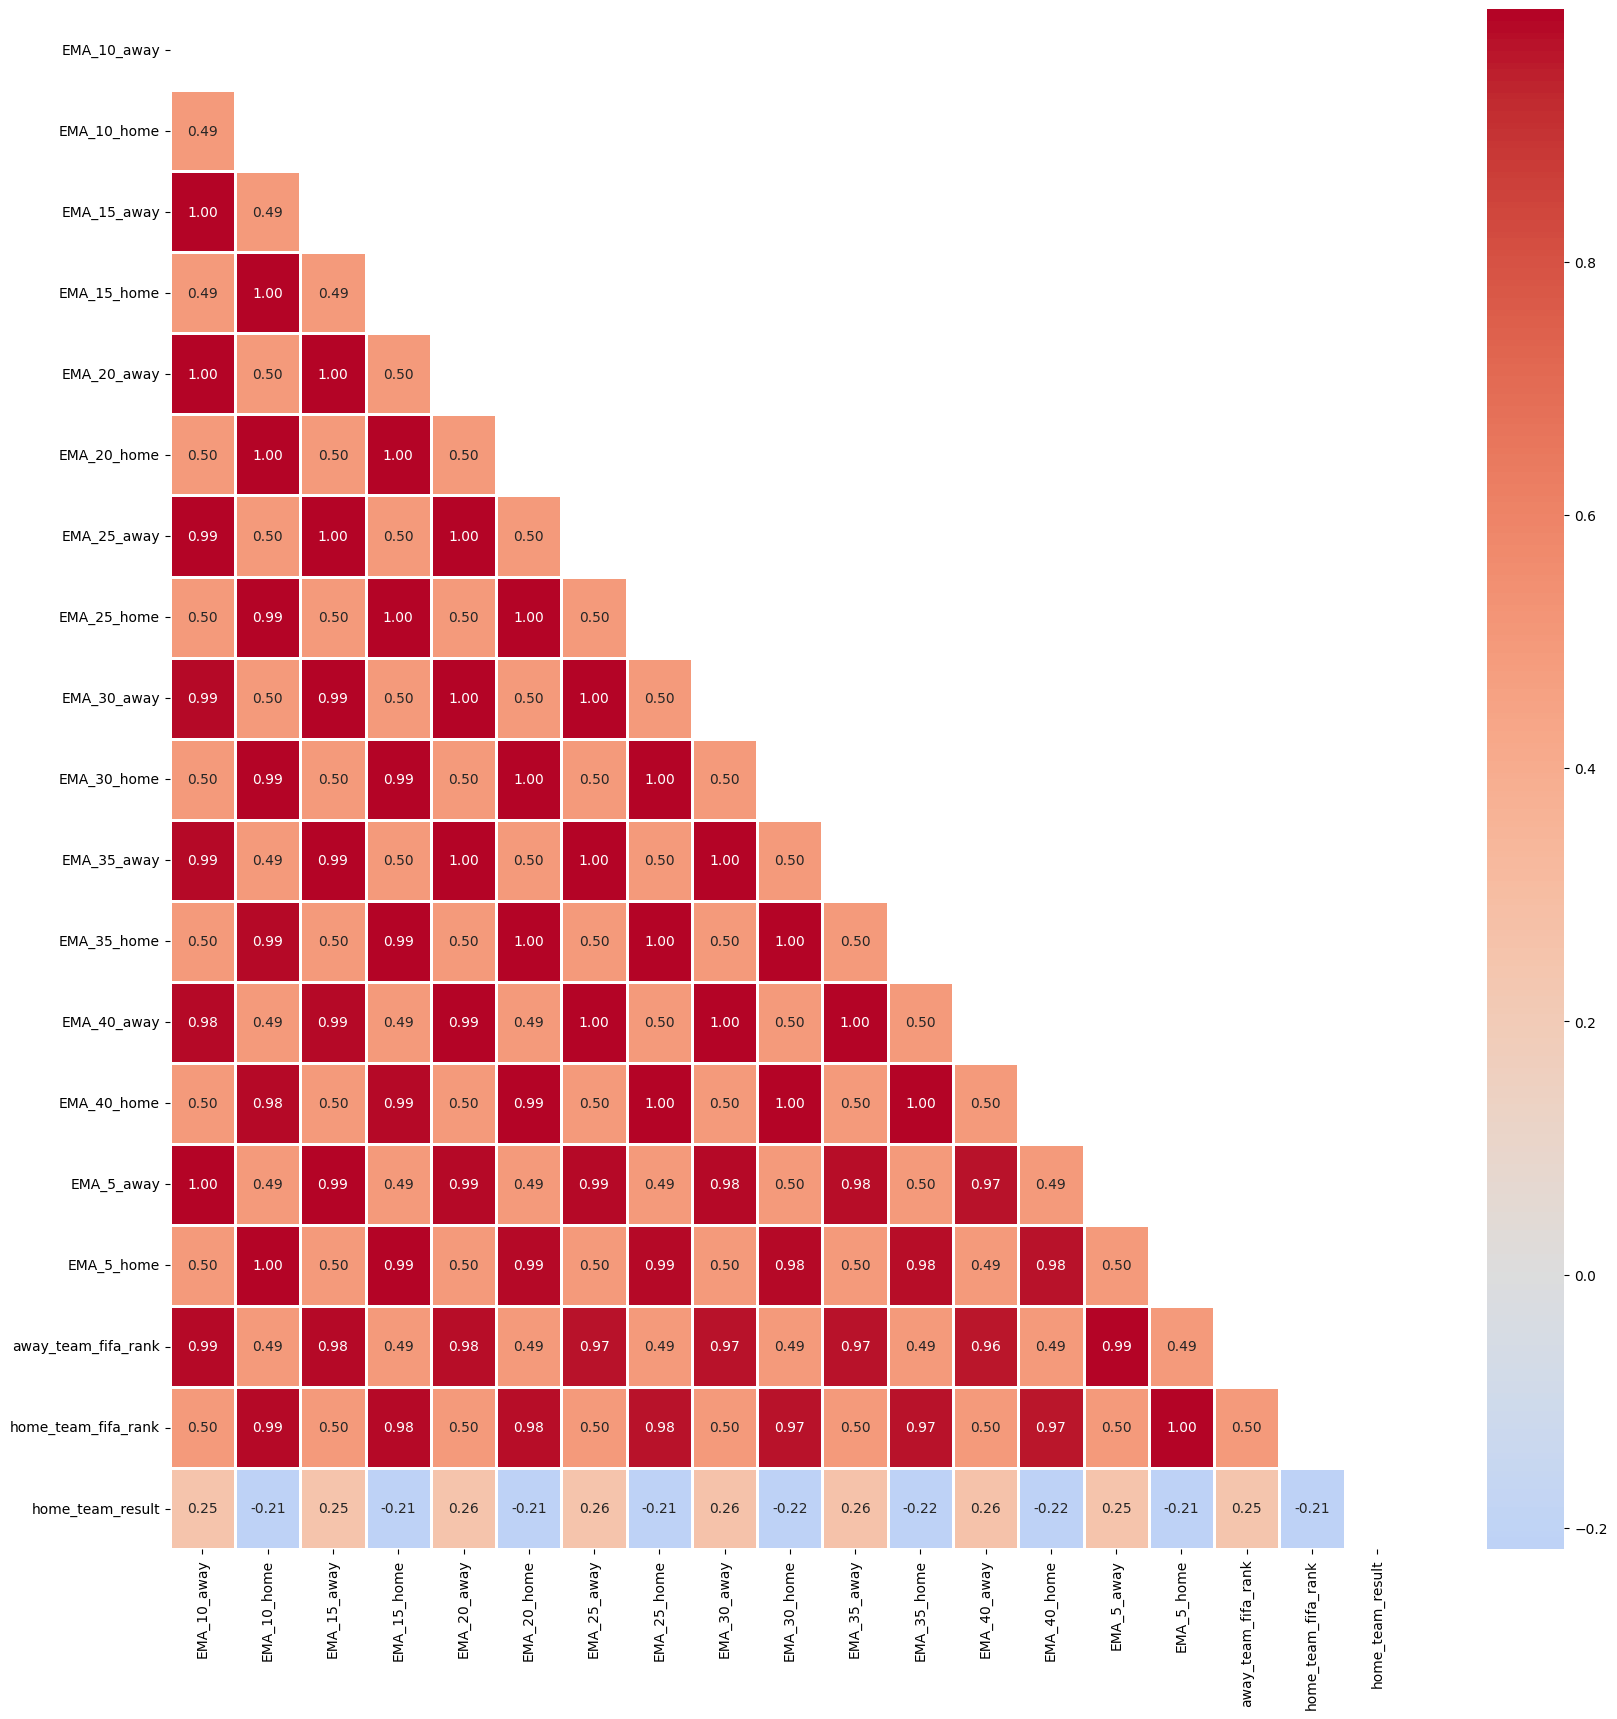

In [274]:
continuous_correlation = sorted(cols) + dependent
correlation = df[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f", annot=True)

### 5.2 Scores

In [279]:
cols = ['home_team_score_total','away_team_score_total','EMA_5_home_scores','EMA_20_home_scores','EMA_5_away_scores','EMA_20_away_scores', 'EMA_40_home_scores','EMA_40_away_scores','EMA_5_home_scores_TS','EMA_5_away_scores_TS','EMA_20_home_scores_TS','EMA_20_away_scores_TS','EMA_40_home_scores_TS','EMA_40_away_scores_TS']

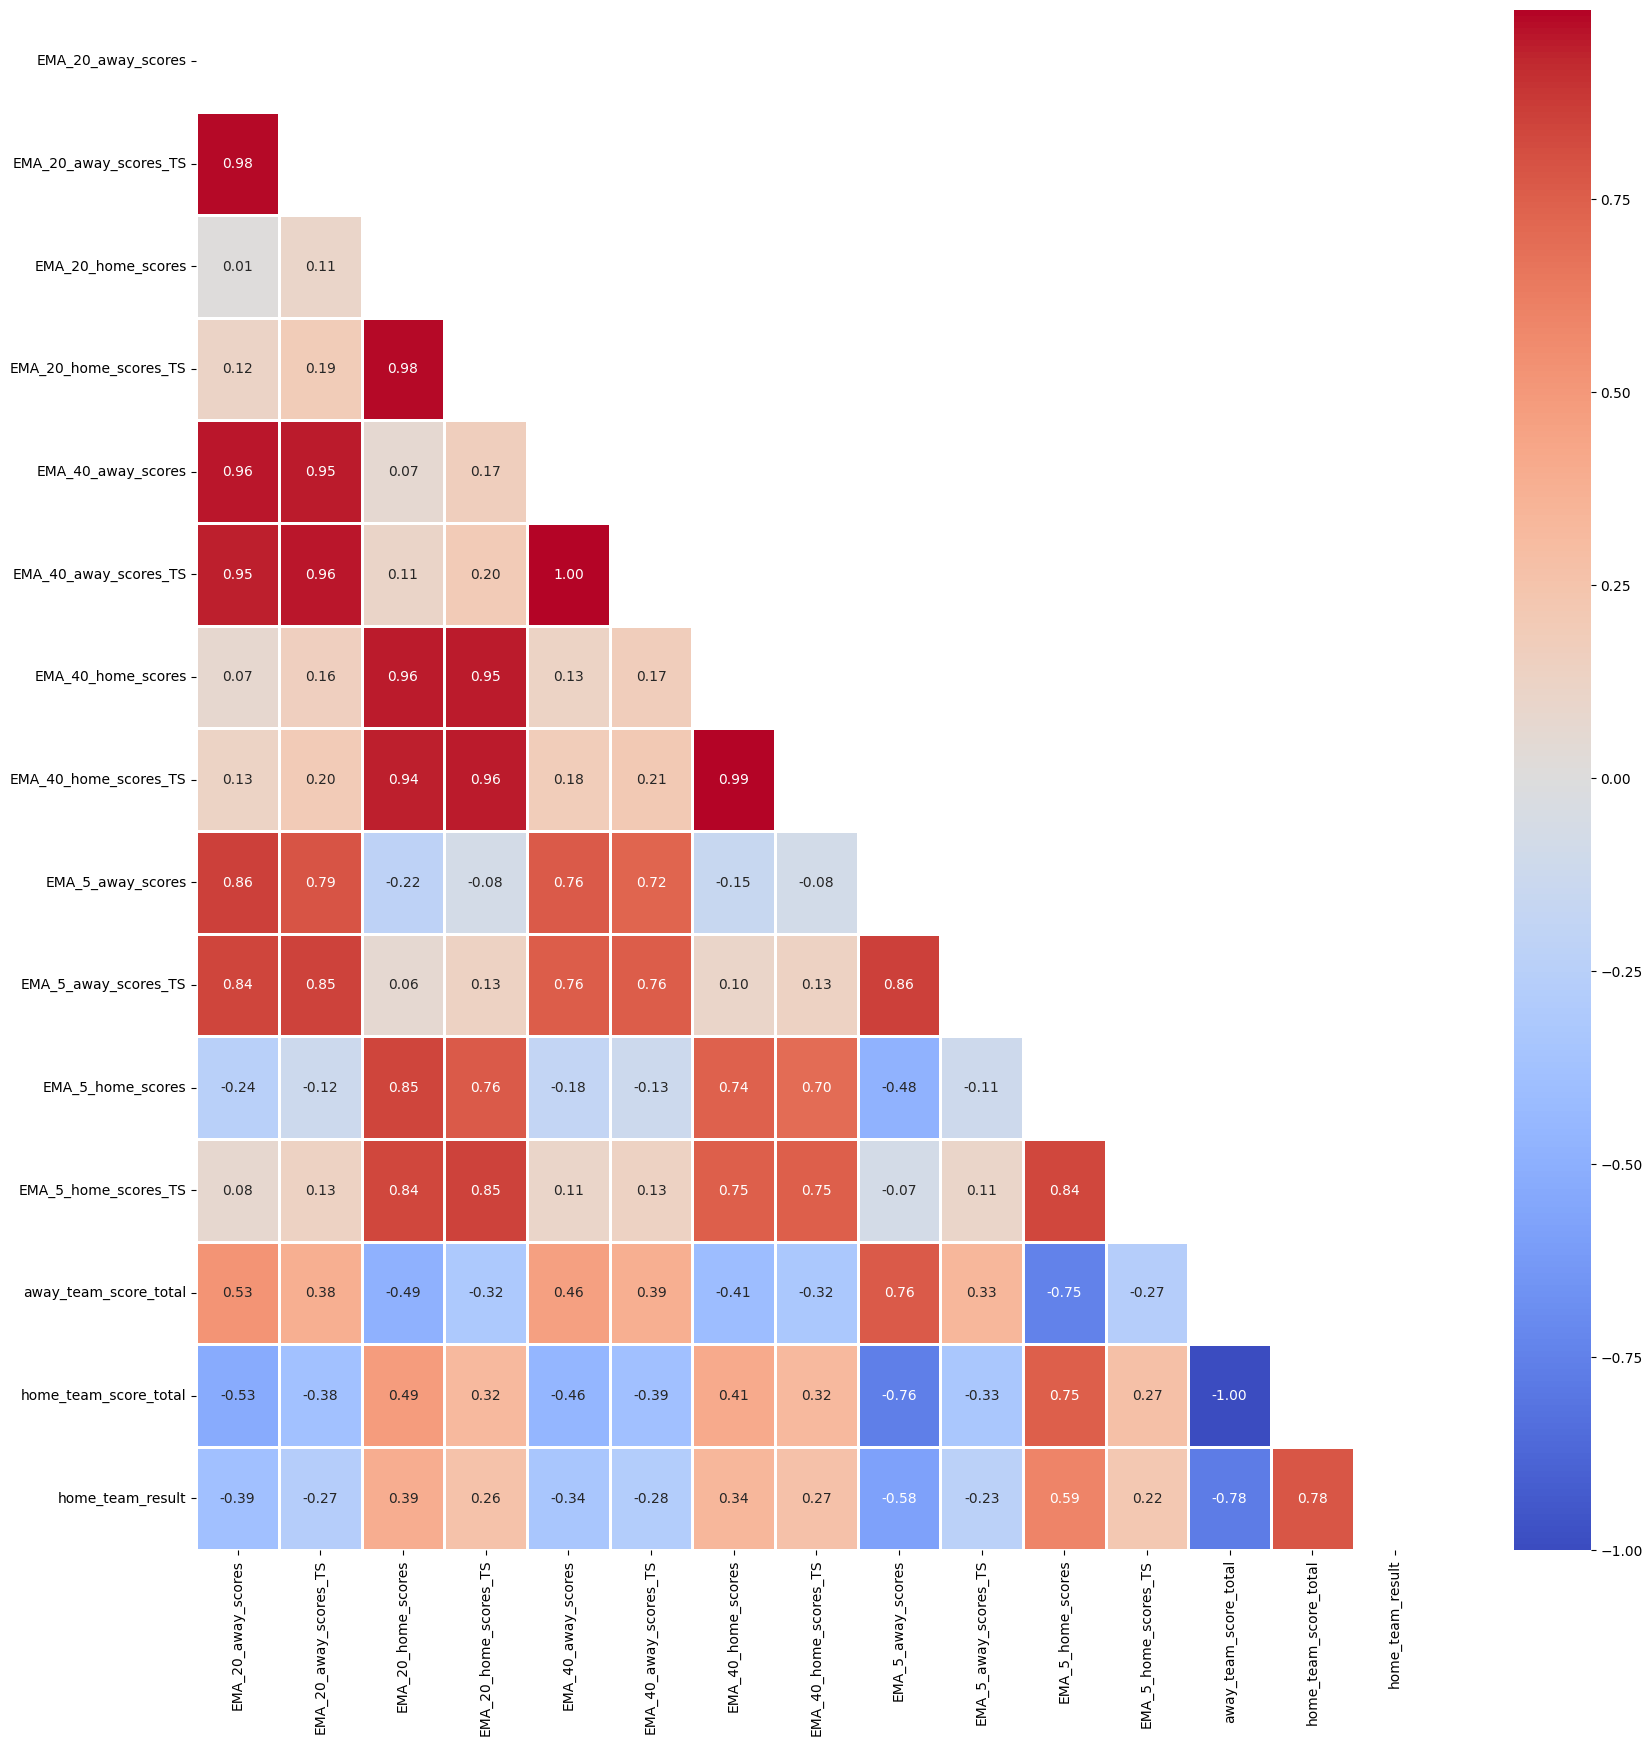

In [280]:
continuous_correlation = sorted(cols) + dependent
correlation = df[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f", annot=True)

### 5.3 offensive/midfield/defense/goalkeeper

In [281]:
cols = ['home_team_goalkeeper_score','home_team_defense_score','home_team_midfield_score','home_team_offense_score','away_team_goalkeeper_score','away_team_defense_score','away_team_midfield_score','away_team_offense_score', 'total_players_score_home','total_players_score_away']

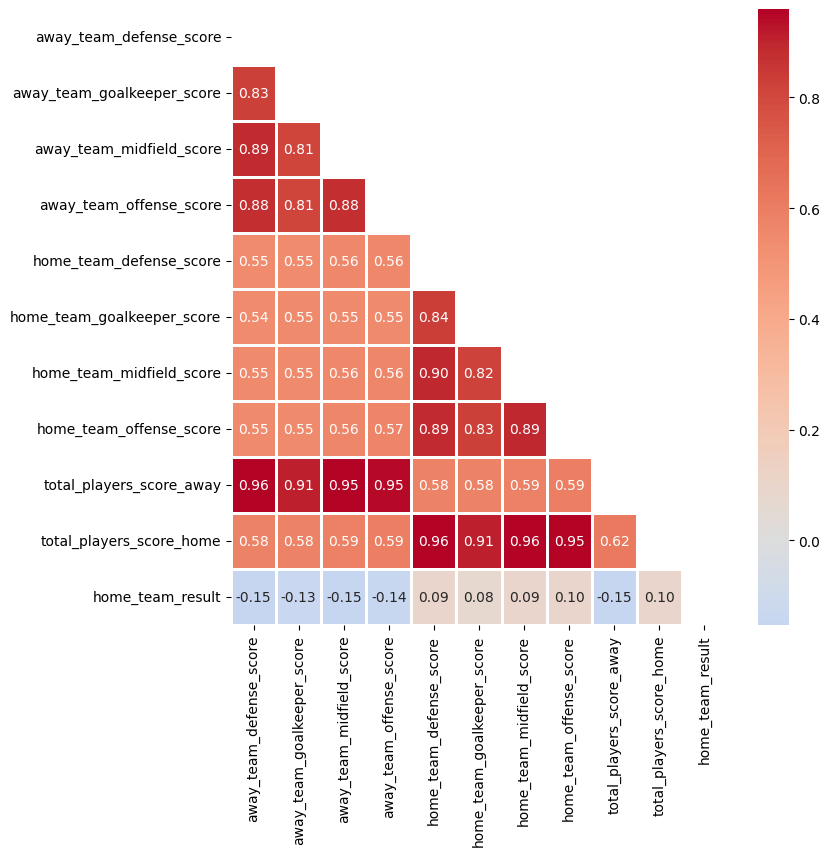

In [282]:
continuous_correlation = sorted(cols) + dependent
correlation = df[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(8,8), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f", annot=True)

In [283]:
cols = ['EMA_5_home_tps','EMA_10_home_tps','EMA_15_home_tps', 'EMA_20_home_tps','EMA_5_away_tps','EMA_10_away_tps','EMA_15_away_tps','EMA_20_away_tps','EMA_25_home_tps','EMA_30_home_tps','EMA_35_home_tps', 'EMA_40_home_tps','EMA_25_away_tps','EMA_30_away_tps','EMA_35_away_tps','EMA_40_away_tps']

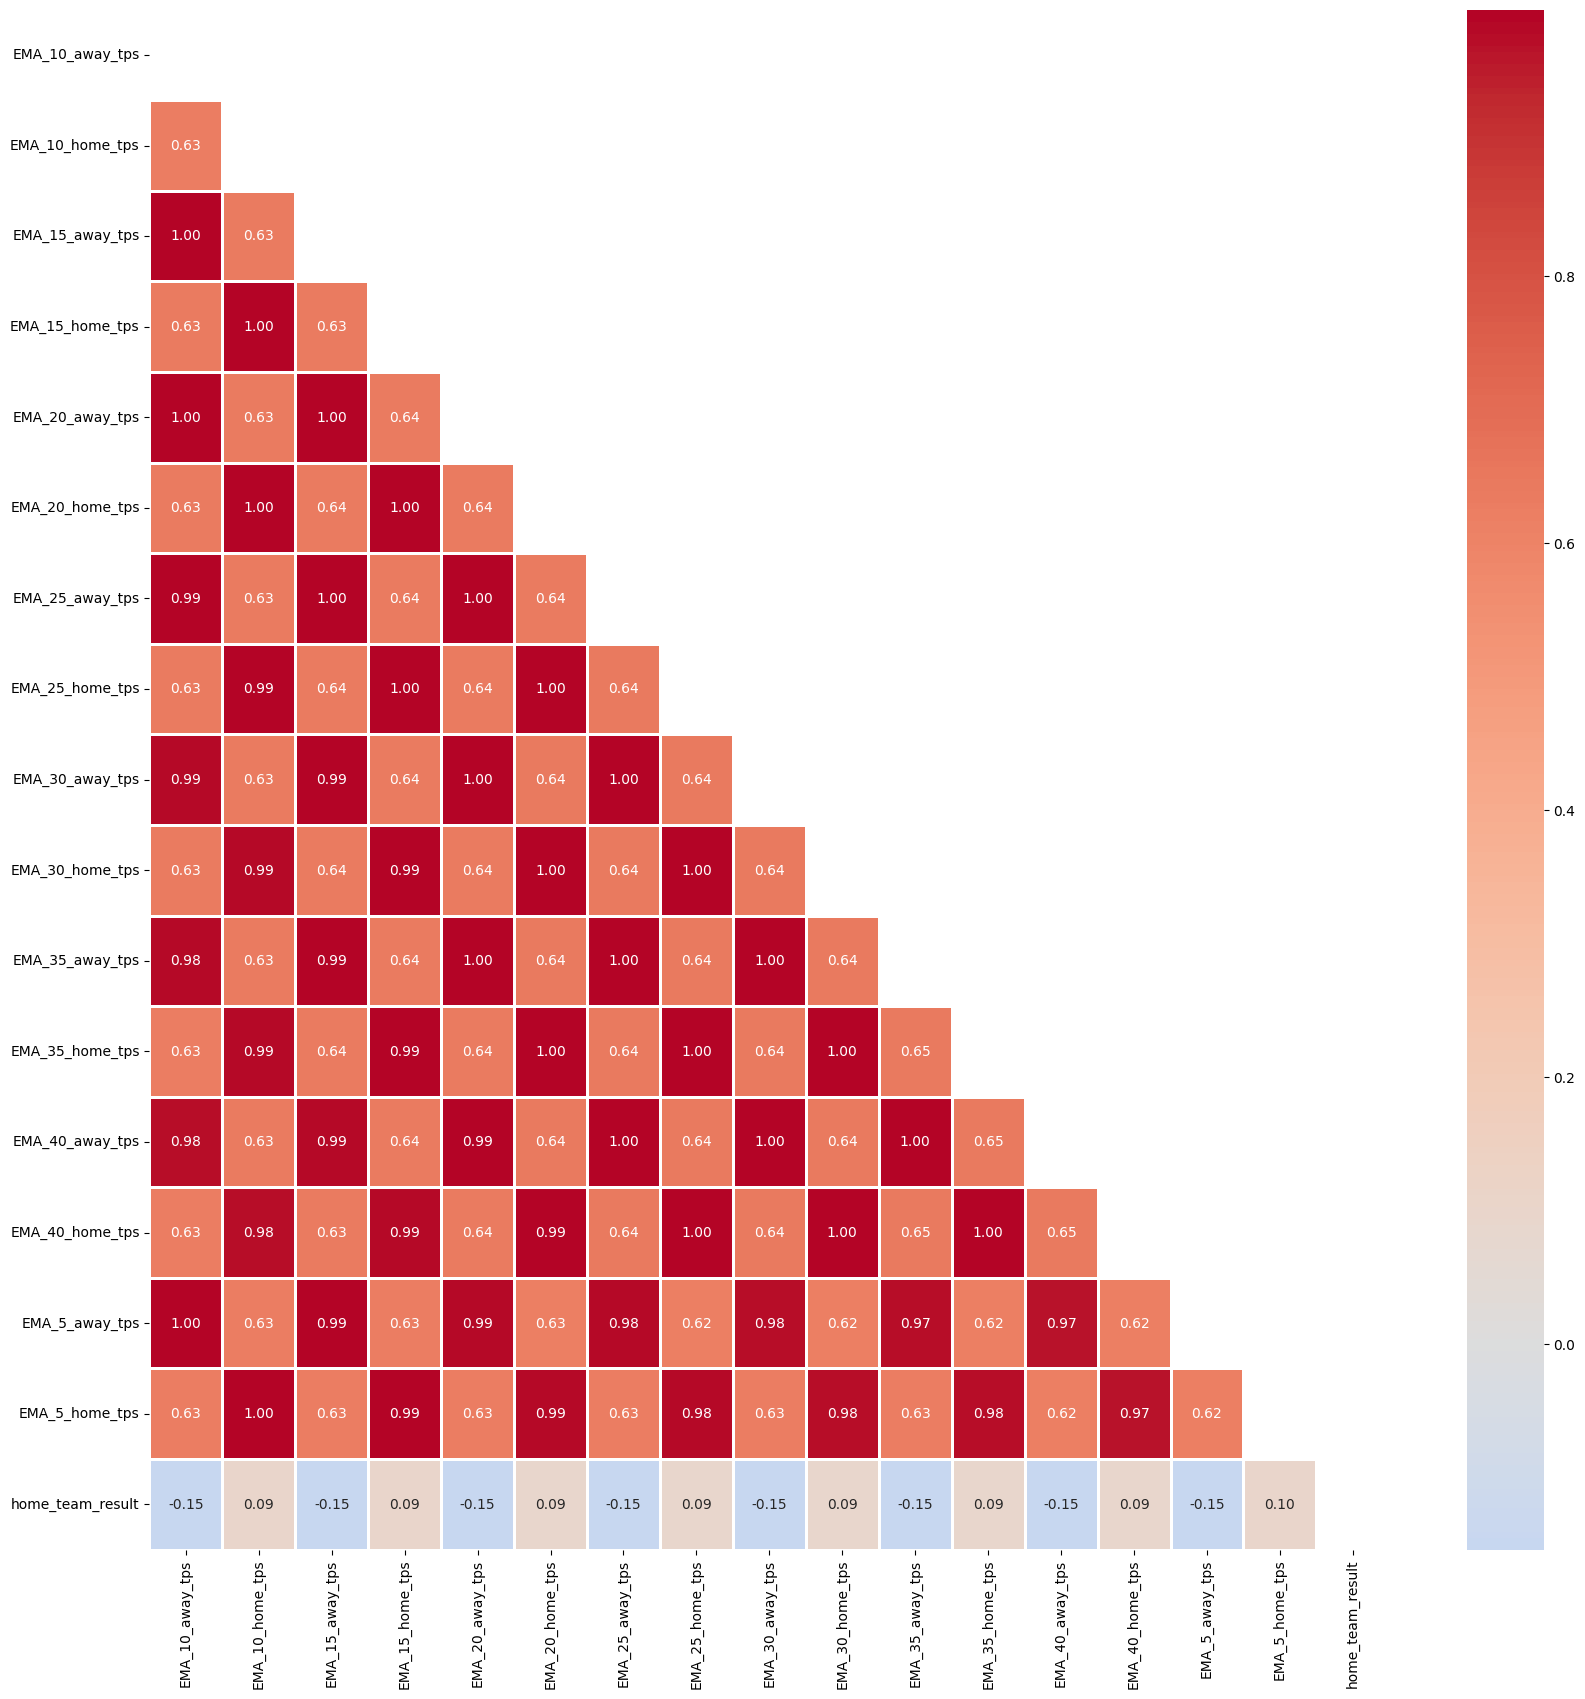

In [284]:
continuous_correlation = sorted(cols) + dependent
correlation = df[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f", annot=True)

### 5.4 results

In [291]:
cols = ['EMA_5_home_results','EMA_20_home_results','EMA_5_away_results','EMA_20_away_results','EMA_40_home_results','EMA_40_away_results','EMA_5_home_results_TS','EMA_5_away_results_TS','EMA_20_home_results_TS','EMA_20_away_results_TS','EMA_40_home_results_TS','EMA_40_away_results_TS']

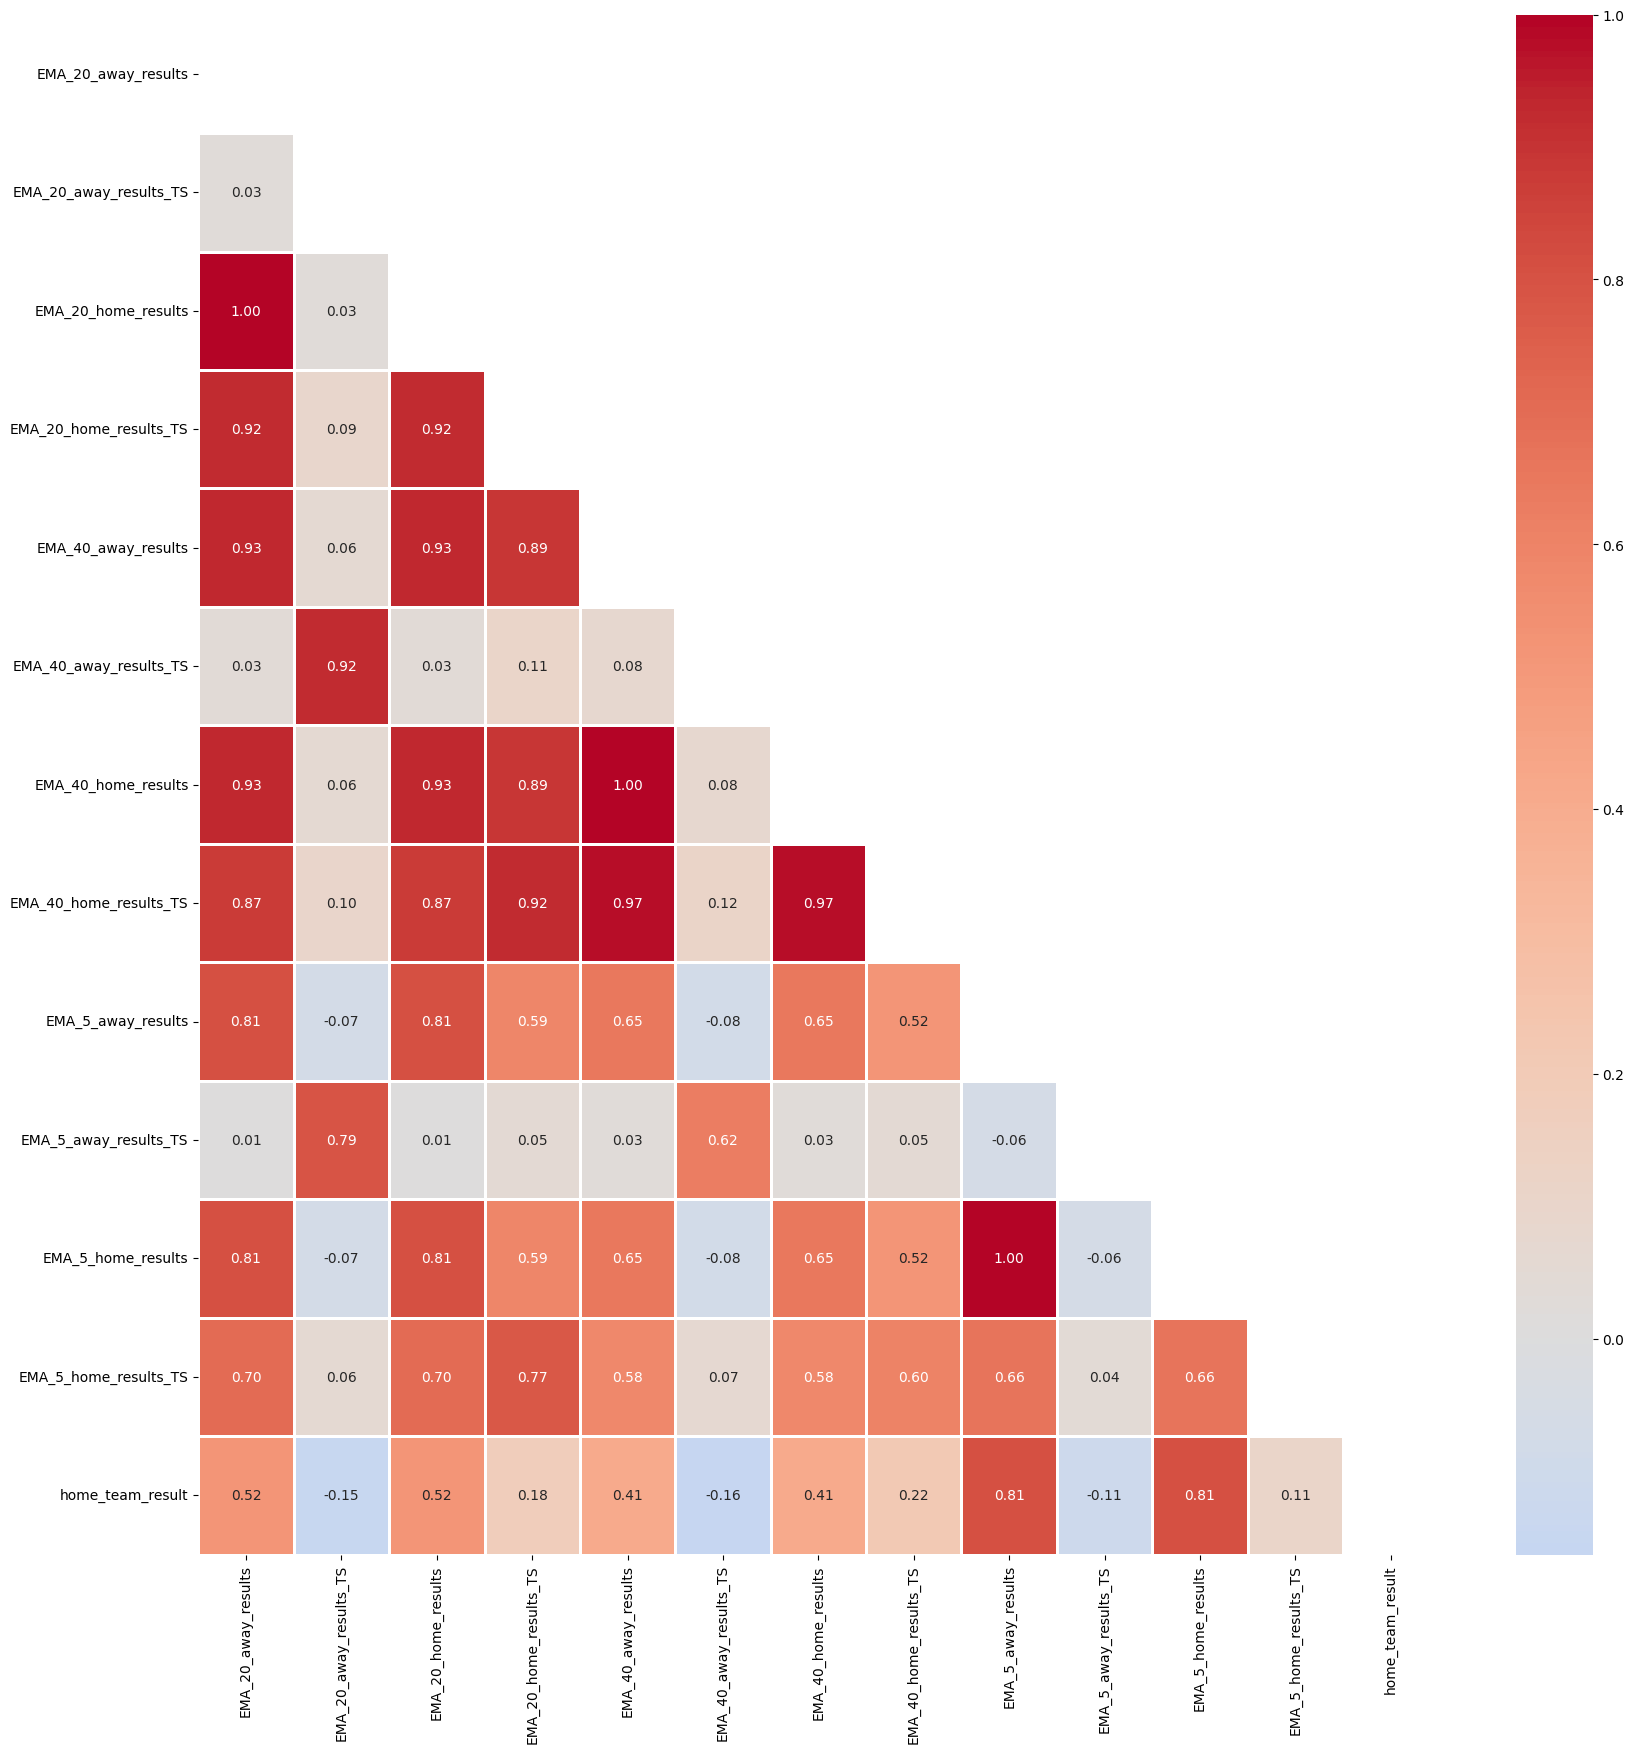

In [292]:
continuous_correlation = sorted(cols) + dependent
correlation = df[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f", annot=True)

### 5.x all numerical columns

In [128]:
cols = [x for x in df.select_dtypes([np.number]).columns]
cols.remove('home_team_result')

dependent = ['home_team_result']

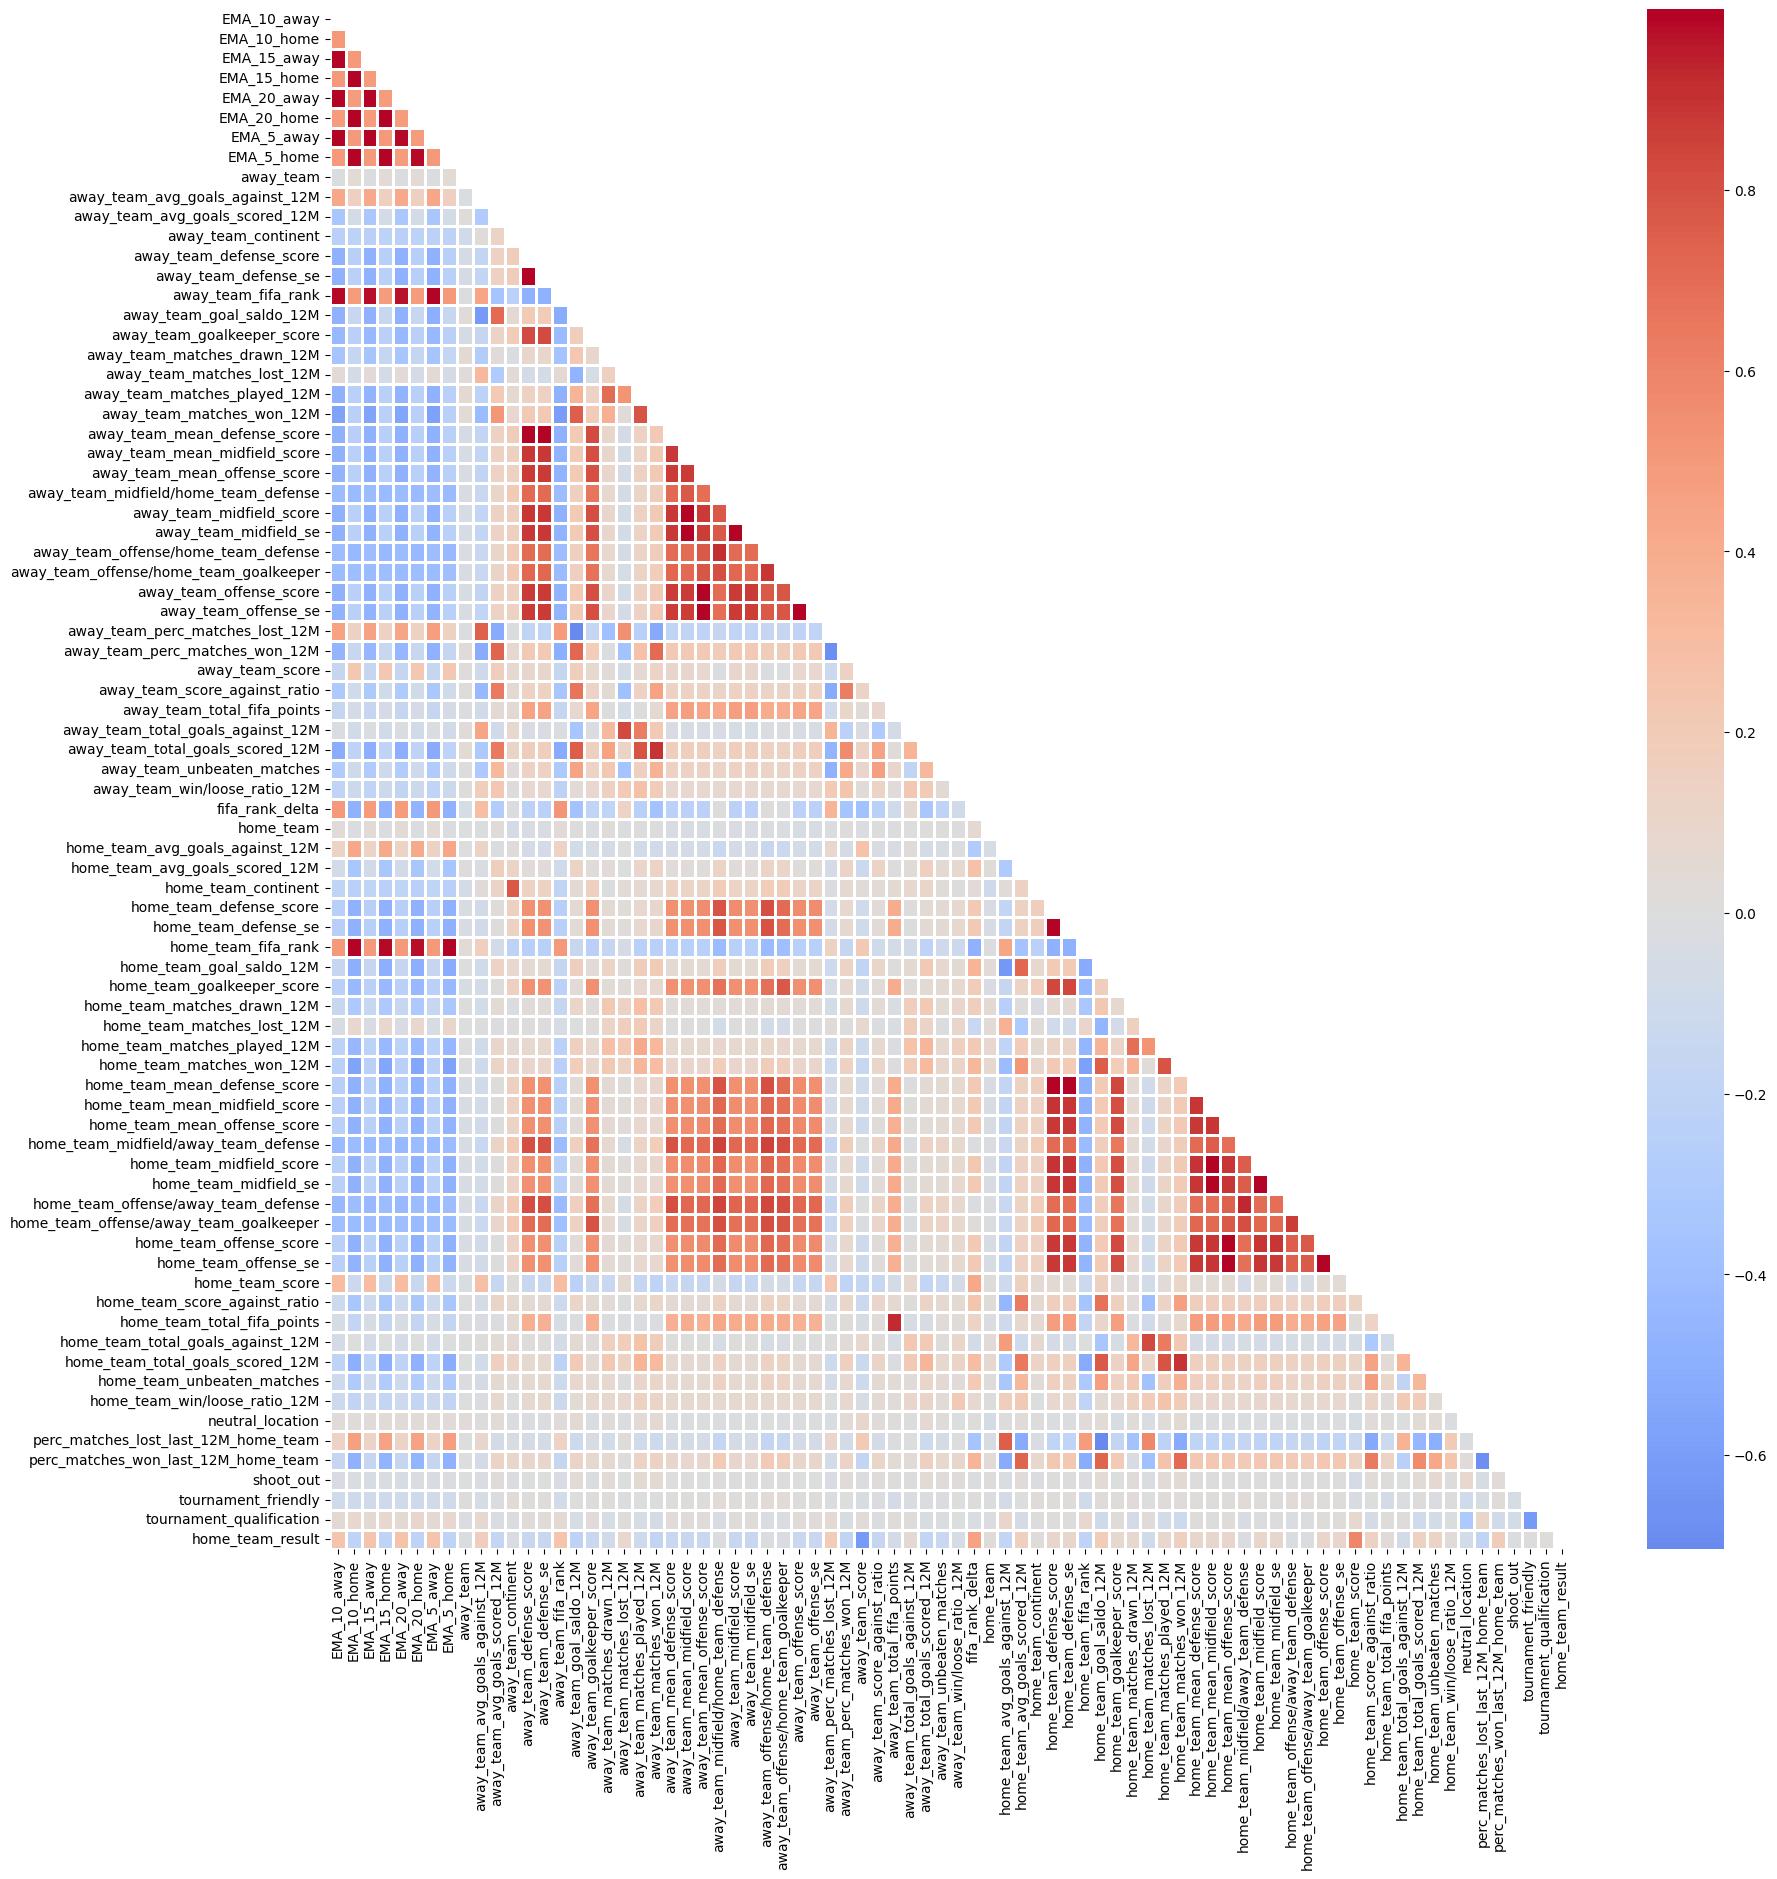

In [131]:
continuous_correlation = sorted(cols) + dependent
correlation = df[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f", annot=False)